In [1]:
import os
import logging
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '0'
warnings.filterwarnings('ignore')
logging.getLogger('tensorflow').setLevel(logging.FATAL)


In [2]:
import os
import pandas as pd

# Define the directory containing processed data files
PROCESSED_DATA = os.path.join("data", "processed-data")

# File paths for processed data
btc_processed_file = os.path.join(PROCESSED_DATA, "btc_1min_processed.csv.gz")
eth_processed_file = os.path.join(PROCESSED_DATA, "eth_1min_processed.csv.gz")
combined_file = os.path.join(PROCESSED_DATA, "crypto_1min_combined.csv.gz")
NEWS_FILTERED_CSV = os.path.join(PROCESSED_DATA, "aggregated-news_filtered.csv.gz")

# File paths for data with features
btc_features_file = os.path.join(PROCESSED_DATA, "btc_1min_with_features.csv.gz")
eth_features_file = os.path.join(PROCESSED_DATA, "eth_1min_with_features.csv.gz")

# File paths for targets
btc_target_file = os.path.join(PROCESSED_DATA, "btc_1min_targets.csv.gz")
eth_target_file = os.path.join(PROCESSED_DATA, "eth_1min_targets.csv.gz")

# Load processed data
btc_df = pd.read_csv(btc_processed_file, compression="gzip")
eth_df = pd.read_csv(eth_processed_file, compression="gzip")
crypto_df = pd.read_csv(combined_file, compression="gzip")
df_filtered_news = pd.read_csv(NEWS_FILTERED_CSV, compression="gzip")

# Load feature data
btc_df_features = pd.read_csv(btc_features_file, compression="gzip")
eth_df_features = pd.read_csv(eth_features_file, compression="gzip")

# Load target data
btc_targets = pd.read_csv(btc_target_file, compression="gzip")
eth_targets = pd.read_csv(eth_target_file, compression="gzip")




In [18]:
# Set percentage of dataset to use (for fast testing)
DATA_PERCENT = 0.01  
DATA_PERCENT_DISPLAY = int(DATA_PERCENT * 100)
PLOTS_DIR = f"Plots_{DATA_PERCENT_DISPLAY}Percent"
os.makedirs(PLOTS_DIR, exist_ok=True)

# Target column name
TARGET_COL = "btc_Close_1m_later"

# Time window length for GRU sequence input
TIME_STEPS = 30


In [8]:
# Merge features and targets
btc_merged = pd.concat([btc_df_features, btc_targets], axis=1)

# Subset the first N% of data (preserving time order)
subset_size = int(len(btc_merged) * DATA_PERCENT)
btc_subset = btc_merged.iloc[:subset_size].copy()

print(f"Subset size: {btc_subset.shape}")


Subset size: (62834, 46)


In [9]:
from sklearn.preprocessing import MinMaxScaler

# Split into features and target
X = btc_subset.drop(columns=[TARGET_COL])
y = btc_subset[TARGET_COL]

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Target stays unscaled for now (or scale separately if needed)
y_array = y.values


In [10]:
import numpy as np

def create_sequences(features, target, time_steps=30):
    Xs, ys = [], []
    for i in range(len(features) - time_steps):
        Xs.append(features[i : i + time_steps])
        ys.append(target[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_array, time_steps=TIME_STEPS)

print(f"X_seq shape: {X_seq.shape}")
print(f"y_seq shape: {y_seq.shape}")


X_seq shape: (62804, 30, 45)
y_seq shape: (62804,)


In [11]:
# Time-series split
train_size = int(len(X_seq) * 0.8)

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]
X_test  = X_seq[train_size:]
y_test  = y_seq[train_size:]

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}")


Train: (50243, 30, 45), (50243,)
Test:  (12561, 30, 45), (12561,)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(GRU(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                21312     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21,377
Trainable params: 21,377
Non-trainable params: 0
_________________________________________________________________


2025-04-06 22:36:32.405054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-06 22:36:32.406351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-06 22:36:32.407250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import os

MODEL_DIR = "models"
LOGS_DIR = "logs"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

model_name = f"gru_btc_model_{int(DATA_PERCENT*100)}pct.h5"
log_name = f"gru_btc_log_{int(DATA_PERCENT*100)}pct.csv"

checkpoint = ModelCheckpoint(os.path.join(MODEL_DIR, model_name), monitor="val_loss", save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
csv_logger = CSVLogger(os.path.join(LOGS_DIR, log_name))

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint, early_stop, csv_logger],
    verbose=1
)


/apps/bdi-venv-310/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/20


2025-04-06 22:36:47.854804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8903
2025-04-06 22:36:48.774429: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1570/1571 [============================>.] - ETA: 0s - loss: 0.9344    
Epoch 1: val_loss improved from inf to 0.10129, saving model to models/gru_btc_model_1pct.h5
1571/1571 [==============================] - 45s 28ms/step - loss: 0.9344 - val_loss: 0.1013
Epoch 2/20
1571/1571 [==============================] - ETA: 0s - loss: 0.2768 
Epoch 2: val_loss improved from 0.10129 to 0.02277, saving model to models/gru_btc_model_1pct.h5
1571/1571 [==============================] - 44s 28ms/step - loss: 0.2768 - val_loss: 0.0228
Epoch 3/20
1570/1571 [============================>.] - ETA: 0s - loss: 0.2501 
Epoch 3: val_loss did not improve from 0.02277
1571/1571 [==============================] - 44s 28ms/step - loss: 0.2502 - val_loss: 0.1312
Epoch 4/20
1570/1571 [============================>.] - ETA: 0s - loss: 0.2323 
Epoch 4: val_loss improved from 0.02277 to 0.00884, saving model to models/gru_btc_model_1pct.h5
1571/1571 [==============================] - 44s 28ms/step - loss: 0.2323 -

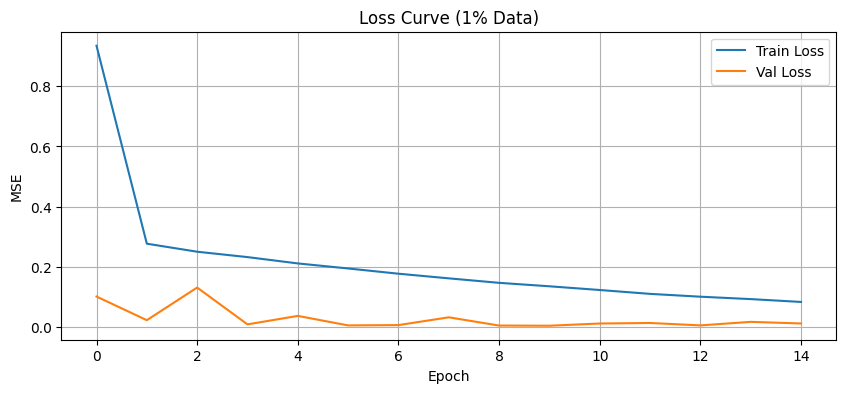

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f"Loss Curve ({DATA_PERCENT_DISPLAY}% Data)")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
loss_curve_path = os.path.join(PLOTS_DIR, "loss_curve.png")
plt.savefig(loss_curve_path)
plt.show()


393/393 [==============================] - 2s 5ms/step


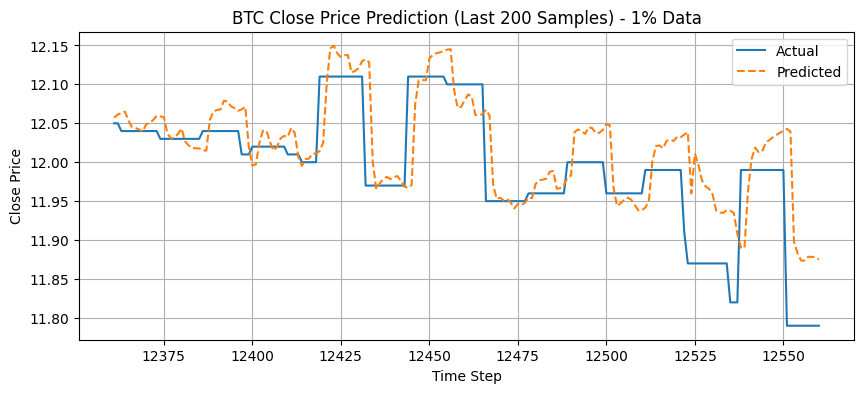

In [15]:
y_pred = model.predict(X_test)

import pandas as pd
comparison_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred.flatten()
})

plt.figure(figsize=(10,4))
plt.plot(comparison_df["Actual"][-200:], label="Actual")
plt.plot(comparison_df["Predicted"][-200:], label="Predicted", linestyle="--")
plt.title(f"BTC Close Price Prediction (Last 200 Samples) - {int(DATA_PERCENT*100)}% Data")
plt.xlabel("Time Step")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


Sample Run

Metrics for 1% dataset:
MSE:  0.0044
RMSE: 0.0662
MAE:  0.0487

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(comparison_df["Actual"], comparison_df["Predicted"])
rmse = np.sqrt(mse)
mae = mean_absolute_error(comparison_df["Actual"], comparison_df["Predicted"])

print(f"Metrics for {int(DATA_PERCENT*100)}% dataset:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")


Metrics for 1% dataset:
MSE:  0.0044
RMSE: 0.0662
MAE:  0.0487
